# Intro to SMuRF
The SMuRF software consists of a server and client.  The server and client are started in docker containers.  The SMuRF server provides and EPICS channel access interface to access PVs (registers, and higher level controls) and acquires the streaming data.  It can perform filtering/downsampling for CMB applications.



## Server startup

In a separate terminal we'll start the server with:
```bash
cd /home/cryo/docker/smurf/dev_sw/slotN/v4.1.0
./run.sh -N 2; docker logs -f smurf_server_s2
```
<font color=red> -N 2 </font> specifies slot 2 and EPICS server prefix smurf_server_s4

A GUI will pop up that we can use to interrogate the FPGA registers


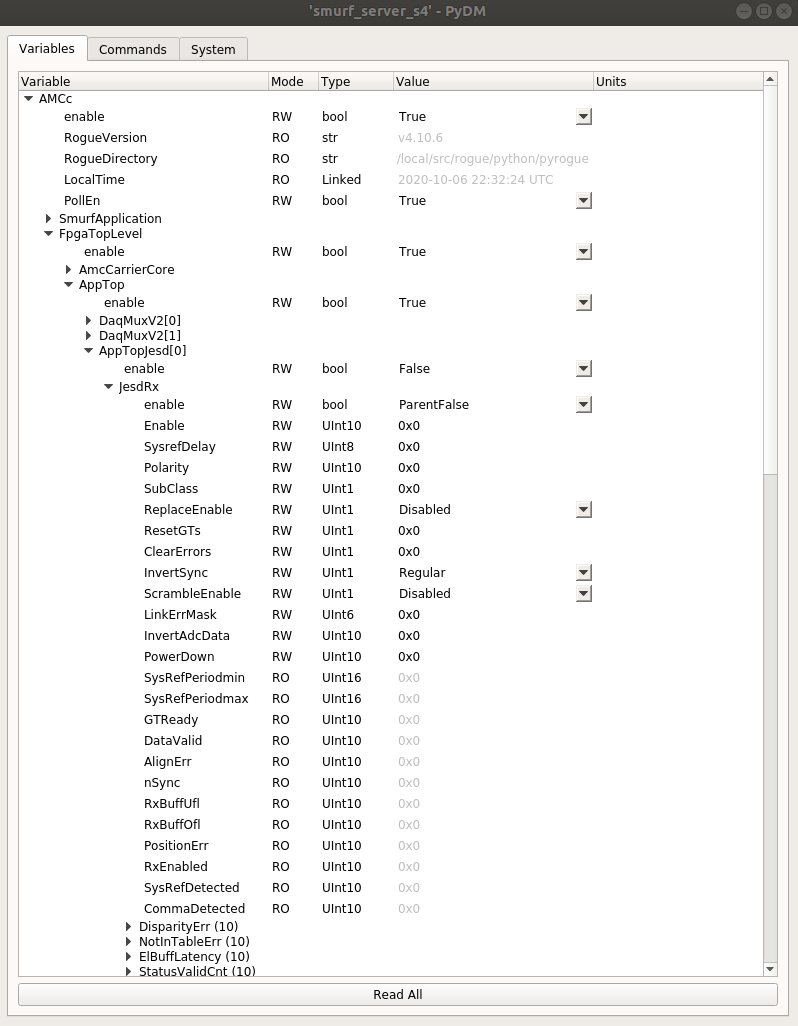

## PySMuRF Setup

PySMuRF is the client side control.  It communicates with the server via EPICS channel access (CA).  First we start the server and do imports

In [1]:
import pysmurf.client
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import epics
import os

%matplotlib inline

Next we'll define the EPICS server prefix and experiment configuration file

In [4]:
epics_prefix = "smurf_server_s2"
config_file  = "/usr/local/src/pysmurf/cfg_files/caltech/tkid/experiment_tkid_lbOnlyBay0.cfg"
S = pysmurf.client.SmurfControl(epics_root=epics_prefix, cfg_file=config_file, setup=False, make_logfile=False)

Next we run a setup command.  This will initialize the FPGA and load the configuration defined in config_file.

In [5]:
S.setup()

[ 2020-10-09 15:34:21 ]  Setting up...
[ 2020-10-09 15:34:21 ]  Toggling DACs
[ 2020-10-09 15:34:21 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:MicrowaveMuxCore[0]:DBG:dacReset[0] 1
[ 2020-10-09 15:34:21 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:MicrowaveMuxCore[0]:DBG:dacReset[1] 1
[ 2020-10-09 15:34:21 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:MicrowaveMuxCore[0]:DBG:dacReset[0] 0
[ 2020-10-09 15:34:21 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:MicrowaveMuxCore[0]:DBG:dacReset[1] 0
[ 2020-10-09 15:34:21 ]  caput smurf_server_s2:AMCc:ReadAll 1
[ 2020-10-09 15:34:27 ]  Waiting 20.00 seconds after...
[ 2020-10-09 15:34:47 ]  Done waiting.
[ 2020-10-09 15:34:47 ]  caget smurf_server_s2:AMCc:SmurfApplication:SmurfVersion
[ 2020-10-09 15:34:47 ]  4.1.0
[ 2020-10-09 15:34:47 ]  caput smurf_server_s2:AMCc:setDefaults 1
[ 2020-10-09 15:35:22 ]  caget smurf_server_s2:AMCc:SmurfApplication:ConfiguringInProgress
[ 2020-10-09 15:35:29 ]

[ 2020-10-09 15:35:33 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:dspEnable 1
[ 2020-10-09 15:35:33 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:CryoChannels:gradientDescentGain 0.0001
[ 2020-10-09 15:35:33 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:CryoChannels:gradientDescentAverages 1
[ 2020-10-09 15:35:33 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:CryoChannels:gradientDescentConvergeHz 500.0
[ 2020-10-09 15:35:33 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:CryoChannels:gradientDescentStepHz 1000.0
[ 2020-10-09 15:35:33 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:CryoChannels:gradientDescentMomentum 1
[ 2020-10-09 15:35:33 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:CryoChannels:gradientDescentBeta 0.0
[ 2020-10-09 15:35:33 ]  caput smurf_server_s2:AMCc:F

[ 2020-10-09 15:35:36 ]  {'hemt_Vg': 0.53999856, 'hemt_Id': -0.16758, '50K_Vg': -0.7574992128000001, '50K_Id': -0.4963}
[ 2020-10-09 15:35:36 ]  {'hemt_Vg': 0.53999856, 'hemt_Id': -0.16758, '50K_Vg': -0.7574992128000001, '50K_Id': -0.4963}
[ 2020-10-09 15:35:36 ]  Cryocard temperature = -8.928571428571429
[ 2020-10-09 15:35:36 ]  Configuring the system to take timing from backplane
[ 2020-10-09 15:35:36 ]  Setting crossbar OutputConfig[1]=0x2 (TO_FPGA=FROM_BACKPLANE)
[ 2020-10-09 15:35:36 ]  Waiting 1 sec for timing up-link...
[ 2020-10-09 15:35:37 ]  Timing RxLinkUp = 0
[ 2020-10-09 15:35:37 ]  Configuring bay 0 LMK to lock to the timing system
[ 2020-10-09 15:35:37 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:RtmCryoDet:RampStartMode 1
[ 2020-10-09 15:35:37 ]  Done with setup.


True

### Inspecting the SMuRF digitizers

SMuRF uses x8 RF ADCs and x8 RF DACs.  They are upmixed and combined in via x2 quadruplexers to form 4GHz analog bandwidth from 4-8GHz.  SMuRF uses a 750MHz intermediate frequency withand the RF ADCs and DACs perform down/up conversion to/from complex baseband.  






### Acquiring data from the digitzers

The SMuRF ADC and DACs are pictured below.  We can interrogate the raw ADC/DAC data with the following commands.  Here "band" defines which ADC/DAC to read data from.  Band 0...3 address AMC in the slot 0 digitizers 0...3.

The raw digitizer data is plotted in the top and a PSD is plotted below.  Raw data are 16-bit numbers +32767/-32768.  Let's look at the ADC data with no signals being played out of the DAC.



[ 2020-10-09 15:40:44 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 65536
[ 2020-10-09 15:40:44 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2020-10-09 15:40:45 ]  ADC plot saved to /data/smurf_data/20201009/1602257653/plots/1602258045_adc0.png
[ 2020-10-09 15:40:45 ]  Saving raw adc data to /data/smurf_data/20201009/1602257653/outputs/1602258045_adc0


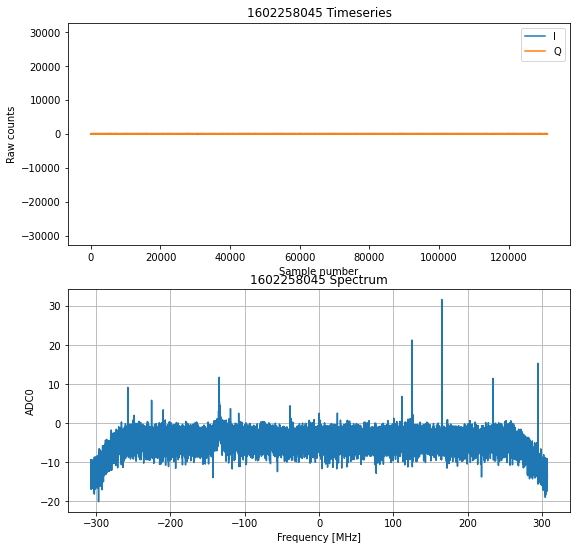

In [6]:
adc_data = S.read_adc_data(data_length=2**16, band=0, do_plot=True, show_plot=True)

[ 2020-10-09 15:40:49 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 65536
[ 2020-10-09 15:40:49 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0


/usr/local/src/pysmurf/python/pysmurf/client/util/smurf_util.py:1716: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(f_plot, 10*np.log10(p_dac))


[ 2020-10-09 15:40:50 ]  DAC plot saved to /data/smurf_data/20201009/1602257653/plots/1602258050_dac0.png
[ 2020-10-09 15:40:50 ]  Saving raw dac data to /data/smurf_data/20201009/1602257653/outputs/1602258050_dac0


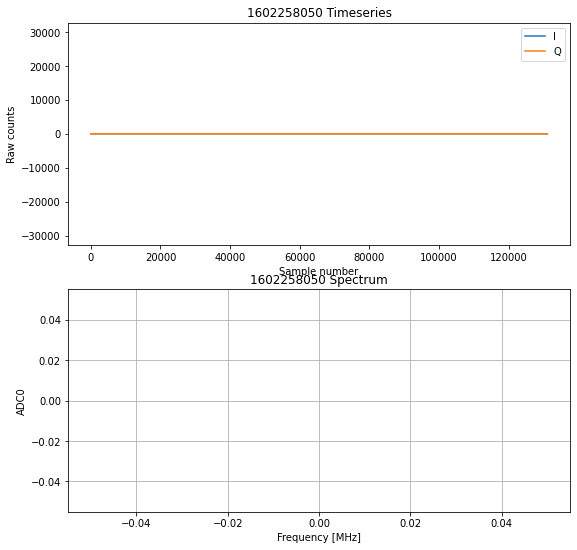

In [7]:
dac_data = S.read_dac_data(data_length=2**16, band=0, do_plot=True, show_plot=True)

Note the PSD frequency is plotted +/- 0MHz. Each digitizer has complex data at 614.4MHz corresponding to +/- 307.2MHz BW at baseband.


### Transfer function of the system

Next we can look at a transfer function estimate.  This will play a known random number sequence through the DAC and record the ADC response.  We'll use cross correlation to generate a transfer function estimate:

[ 2020-10-09 15:41:40 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 4096
[ 2020-10-09 15:41:40 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2020-10-09 15:41:40 ]  ADC0 max count: 2387
[ 2020-10-09 15:41:40 ]  ADC0 min count: -2335
[ 2020-10-09 15:41:40 ]  ADC0 not saturated
[ 2020-10-09 15:41:40 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2020-10-09 15:41:40 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2020-10-09 15:41:41 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2020-10-09 15:41:41 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2020-10-09 15:41:41 ]  UC (DAC) att: 24
[ 2020-10-09 15:41:41 ]  DC (ADC) att: 0
[ 2020-10-09 15:41:41 ]  UC attenuator > 0. Scaling by 0.251


/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1812: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


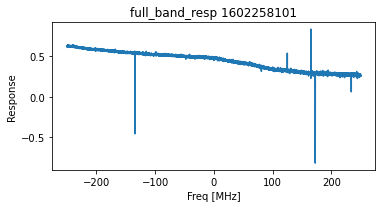

(array([-3.07200012e+08, -3.07197668e+08, -3.07195325e+08, ...,
         3.07192981e+08,  3.07195325e+08,  3.07197668e+08]),
 array([-0.28511747-0.63990591j, -0.28714658-0.62739257j,
        -0.2886098 -0.62145267j, ..., -0.24150835-0.63395009j,
        -0.25946414-0.61740948j, -0.277932  -0.63862794j]))

In [8]:
S.full_band_resp(band=0, make_plot=True, show_plot=True)

Here we can see the two interleaving spurs.

### Identifying resonator locations

Each SMuRF band is processed by an oversampled x2 polyphase filter bank.  The filter bank breaks the +/-307.2MHz band into subbands.  Subband 0...511 correspond to -307.2MHz...307.2MHz.  Only subbands +/-250MHz are processed.  We can do a tone sweep to see the subband structure and identify resonator locations within each subband.  The plot shows the interleaved subbands in different colors.

[ 2020-10-09 15:53:10 ]  Sweeping across frequencies
[ 2020-10-09 15:53:10 ]  Working on band 0
[ 2020-10-09 15:53:10 ]  Sweeping subband no: 0
[ 2020-10-09 15:53:15 ]  Sweeping subband no: 1
[ 2020-10-09 15:53:19 ]  Sweeping subband no: 2
[ 2020-10-09 15:53:23 ]  Sweeping subband no: 3
[ 2020-10-09 15:53:28 ]  Sweeping subband no: 4
[ 2020-10-09 15:53:33 ]  Sweeping subband no: 5
[ 2020-10-09 15:53:37 ]  Sweeping subband no: 6
[ 2020-10-09 15:53:42 ]  Sweeping subband no: 7
[ 2020-10-09 15:53:46 ]  Sweeping subband no: 8
[ 2020-10-09 15:53:50 ]  Sweeping subband no: 9
[ 2020-10-09 15:53:55 ]  Sweeping subband no: 10
[ 2020-10-09 15:54:00 ]  Sweeping subband no: 11
[ 2020-10-09 15:54:05 ]  Sweeping subband no: 12
[ 2020-10-09 15:54:09 ]  Sweeping subband no: 13
[ 2020-10-09 15:54:14 ]  Sweeping subband no: 14
[ 2020-10-09 15:54:19 ]  Sweeping subband no: 15
[ 2020-10-09 15:54:23 ]  Sweeping subband no: 16
[ 2020-10-09 15:54:28 ]  Sweeping subband no: 17
[ 2020-10-09 15:54:32 ]  Sweepin

[ 2020-10-09 16:05:39 ]  Sweeping subband no: 165
[ 2020-10-09 16:05:43 ]  Sweeping subband no: 166
[ 2020-10-09 16:05:48 ]  Sweeping subband no: 167
[ 2020-10-09 16:05:53 ]  Sweeping subband no: 168
[ 2020-10-09 16:05:57 ]  Sweeping subband no: 169
[ 2020-10-09 16:06:01 ]  Sweeping subband no: 170
[ 2020-10-09 16:06:06 ]  Sweeping subband no: 171
[ 2020-10-09 16:06:11 ]  Sweeping subband no: 172
[ 2020-10-09 16:06:15 ]  Sweeping subband no: 173
[ 2020-10-09 16:06:20 ]  Sweeping subband no: 174
[ 2020-10-09 16:06:24 ]  Sweeping subband no: 175
[ 2020-10-09 16:06:29 ]  Sweeping subband no: 176
[ 2020-10-09 16:06:33 ]  Sweeping subband no: 177
[ 2020-10-09 16:06:37 ]  Sweeping subband no: 178
[ 2020-10-09 16:06:42 ]  Sweeping subband no: 179
[ 2020-10-09 16:06:46 ]  Sweeping subband no: 180
[ 2020-10-09 16:06:51 ]  Sweeping subband no: 181
[ 2020-10-09 16:06:56 ]  Sweeping subband no: 182
[ 2020-10-09 16:07:00 ]  Sweeping subband no: 183
[ 2020-10-09 16:07:05 ]  Sweeping subband no: 184


[ 2020-10-09 16:18:28 ]  Sweeping subband no: 329
[ 2020-10-09 16:18:33 ]  Sweeping subband no: 330
[ 2020-10-09 16:18:38 ]  Sweeping subband no: 331
[ 2020-10-09 16:18:43 ]  Sweeping subband no: 332
[ 2020-10-09 16:18:49 ]  Sweeping subband no: 333
[ 2020-10-09 16:18:53 ]  Sweeping subband no: 334
[ 2020-10-09 16:18:58 ]  Sweeping subband no: 335
[ 2020-10-09 16:19:03 ]  Sweeping subband no: 336
[ 2020-10-09 16:19:08 ]  Sweeping subband no: 337
[ 2020-10-09 16:19:13 ]  Sweeping subband no: 338
[ 2020-10-09 16:19:17 ]  Sweeping subband no: 339
[ 2020-10-09 16:19:23 ]  Sweeping subband no: 340
[ 2020-10-09 16:19:28 ]  Sweeping subband no: 341
[ 2020-10-09 16:19:33 ]  Sweeping subband no: 342
[ 2020-10-09 16:19:38 ]  Sweeping subband no: 343
[ 2020-10-09 16:19:43 ]  Sweeping subband no: 344
[ 2020-10-09 16:19:47 ]  Sweeping subband no: 345
[ 2020-10-09 16:19:52 ]  Sweeping subband no: 346
[ 2020-10-09 16:19:58 ]  Sweeping subband no: 347
[ 2020-10-09 16:20:03 ]  Sweeping subband no: 348


[ 2020-10-09 16:31:22 ]  Sweeping subband no: 493
[ 2020-10-09 16:31:26 ]  Sweeping subband no: 494
[ 2020-10-09 16:31:30 ]  Sweeping subband no: 495
[ 2020-10-09 16:31:35 ]  Sweeping subband no: 496
[ 2020-10-09 16:31:39 ]  Sweeping subband no: 497
[ 2020-10-09 16:31:44 ]  Sweeping subband no: 498
[ 2020-10-09 16:31:48 ]  Sweeping subband no: 499
[ 2020-10-09 16:31:54 ]  Sweeping subband no: 500
[ 2020-10-09 16:31:58 ]  Sweeping subband no: 501
[ 2020-10-09 16:32:03 ]  Sweeping subband no: 502
[ 2020-10-09 16:32:07 ]  Sweeping subband no: 503
[ 2020-10-09 16:32:11 ]  Sweeping subband no: 504
[ 2020-10-09 16:32:16 ]  Sweeping subband no: 505
[ 2020-10-09 16:32:21 ]  Sweeping subband no: 506
[ 2020-10-09 16:32:25 ]  Sweeping subband no: 507
[ 2020-10-09 16:32:30 ]  Sweeping subband no: 508
[ 2020-10-09 16:32:35 ]  Sweeping subband no: 509
[ 2020-10-09 16:32:40 ]  Sweeping subband no: 510
[ 2020-10-09 16:32:44 ]  Sweeping subband no: 511


/usr/local/src/pysmurf/python/pysmurf/client/tune/smurf_tune.py:896: RuntimeWarning: invalid value encountered in double_scalars
  if 1-amp[idx]/med_amp[idx] > amp_cut:


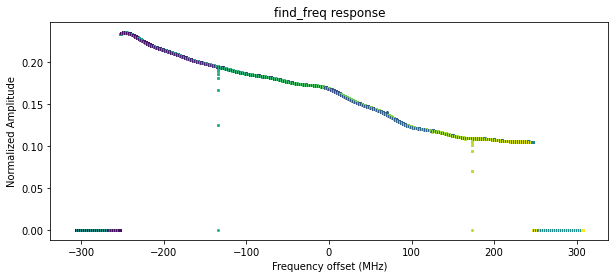

(array([[-306.60001218, -306.59001218, -306.58001218, ..., -305.42001214,
         -305.41001214, -305.40001214],
        [-305.40001214, -305.39001214, -305.38001213, ..., -304.22001209,
         -304.21001209, -304.20001209],
        [-304.20001209, -304.19001209, -304.18001209, ..., -303.02001204,
         -303.01001204, -303.00001204],
        ...,
        [ 304.20001209,  304.21001209,  304.22001209, ...,  305.38001213,
          305.39001214,  305.40001214],
        [ 305.40001214,  305.41001214,  305.42001214, ...,  306.58001218,
          306.59001218,  306.60001218],
        [ 306.60001218,  306.61001218,  306.62001218, ...,  307.78001223,
          307.79001223,  307.80001223]]),
 array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ...

In [11]:
S.find_freq(band=0, subband=d=range(512), tone_power=10, make_plot=True, show_plot=True)

### Fine resolution resonator scans
Next we run a fine resonator scan and set the nominal tone frequency, drive power and rotation.  Feedback operates on the RF demodulated Q and performs feedback to drive Q to 0.  This step enables feedback.

In [7]:
S.setup_notches(0, tone_power=10, sweep_width=1, df_sweep=0.02, new_master_assignment=True)
# Plots will be saved in S.plot_dir
S.plot_tune_summary(0, eta_scan=True)
print("These plots are saved at: " + S.plot_dir)
# run a gradient descent to find resonator dip
S.run_serial_gradient_descent(0) 
# run eta scan to normalize resonator gain (delta Q -> delta frequency) and apply rotation such that Q is nominally 0
S.run_serial_eta_scan(0) 

[ 2020-10-06 23:25:25 ]  freq 4010.4000 - 1 of 4
[ 2020-10-06 23:25:26 ]  freq 4046.2000 - 2 of 4
[ 2020-10-06 23:25:27 ]  freq 4249.9200 - 3 of 4
[ 2020-10-06 23:25:28 ]  freq 4439.6000 - 4 of 4
[ 2020-10-06 23:25:29 ]  Assigning channels
[ 2020-10-06 23:25:29 ]  Writing new channel assignment to /data/smurf_data/tune/1602026730_channel_assignment_b0.txt
[ 2020-10-06 23:25:29 ]  Old master assignment file: /data/smurf_data/tune/1602025192_channel_assignment_b0.txt
[ 2020-10-06 23:25:29 ]  New master assignment file: /data/smurf_data/tune/1602026730_channel_assignment_b0.txt
[ 2020-10-06 23:25:29 ]  Saving to : /data/smurf_data/tune/1602026730_tune.npy
[ 2020-10-06 23:25:29 ]  Relocking...
[ 2020-10-06 23:25:33 ]  Setting on 4 channels on band 0
[ 2020-10-06 23:25:33 ]  Eta plot 1 of 4
[ 2020-10-06 23:25:34 ]  Eta plot 2 of 4
[ 2020-10-06 23:25:34 ]  Eta plot 3 of 4
[ 2020-10-06 23:25:34 ]  Eta plot 4 of 4
These plots are saved at: /data/smurf_data/20201006/1602026584/plots


Here's an example of the eta scan.  The complex response is multiplied by the complex value eta to apply the scaling/rotation for feedback.

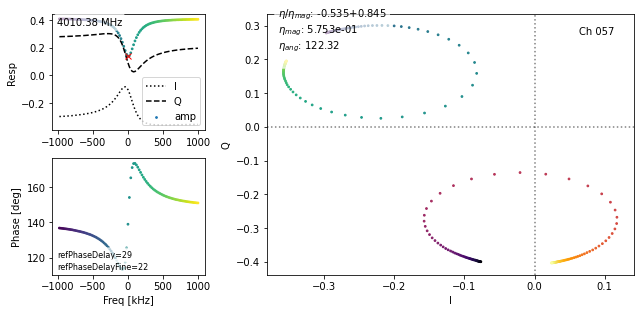

### Feedback gain
Resonator feedback has gain and limit settings.  The previous <font color='red'> eta scan </font> has already scaled each resonator response such that they all have approximatley equal gain to the tracking loop.  We can configure overall gain and feedback limits with:


In [52]:
S.set_feedback_gain(band=0, val=2048)
S.set_feedback_limit_khz(band=0, feedback_limit_khz=100)

We can grab raw resonator data and view the bandwidth to tune the gain.

In [53]:
f, dF, sync = S.take_debug_data(band=0, channel=0, nsamp=2**19, IQstream=0, single_channel_readout=2)

[ 2020-10-09 20:24:01 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:readoutChannelSelect 0
[ 2020-10-09 20:24:01 ]  Writing to file : /data/smurf_data/20201009/1602257653/outputs/1602275041.dat
[ 2020-10-09 20:24:01 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2020-10-09 20:24:01 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2020-10-09 20:24:01 ]  Data acquisition in progress...
[ 2020-10-09 20:24:01 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2020-10-09 20:24:03 ]  Done taking data


Let's plot frequency and error and look at PSD of tracked signal

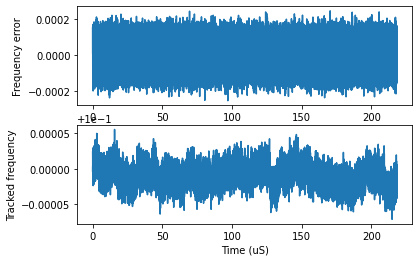

In [54]:
t = np.arange(len(f))
t = t*1000/2.4e6

plt.subplot(211)
plt.plot(t, dF)
plt.xlabel('Time (uS)')
plt.ylabel('Frequency error')

plt.subplot(212)
plt.xlabel('Time (uS)')
plt.ylabel('Tracked frequency')
plt.plot(t, f)

Now let's look at PSD of tracked signal.  We can use this to tune the feedback gain.

Text(0.5, 1.0, 'Tracked frequency spectrum')

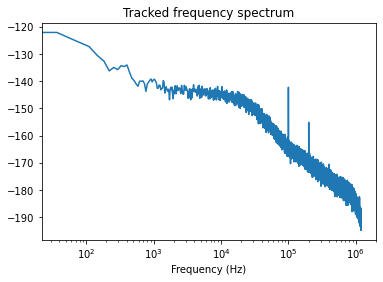

In [57]:
freq, pxx = signal.welch(f, nperseg=len(f)/8, fs=2.4e6)
plt.semilogx(freq, 10*np.log10(pxx))
plt.xlabel('Frequency (Hz)')
plt.title('Tracked frequency spectrum')

Text(0.5, 1.0, 'Frequency error spectrum')

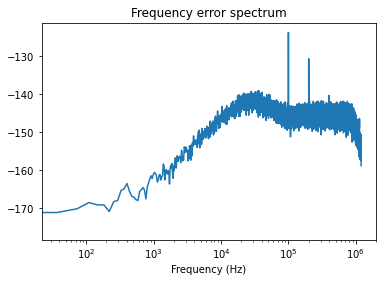

In [58]:
freq, pxx = signal.welch(dF, nperseg=len(f)/8, fs=2.4e6)
plt.semilogx(freq, 10*np.log10(pxx))
plt.xlabel('Frequency (Hz)')
plt.title('Frequency error spectrum')

[ 2020-10-09 20:41:37 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:readoutChannelSelect 0
[ 2020-10-09 20:41:37 ]  Writing to file : /data/smurf_data/20201009/1602257653/outputs/1602276098.dat
[ 2020-10-09 20:41:37 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2020-10-09 20:41:37 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2020-10-09 20:41:37 ]  Data acquisition in progress...
[ 2020-10-09 20:41:37 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2020-10-09 20:41:39 ]  Done taking data
[ 2020-10-09 20:41:40 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:readoutChannelSelect 0
[ 2020-10-09 20:41:40 ]  Writing to file : /data/smurf_data/20201009/1602257653/outputs/1602276100.dat
[ 2020-10-09 20:41:40 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2020-10-09 20:41:40 ]  caput smurf_server_s

/home/cryo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/cryo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


[ 2020-10-09 20:41:45 ]  Done taking data
[ 2020-10-09 20:41:45 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:readoutChannelSelect 0


/home/cryo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/cryo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


[ 2020-10-09 20:41:45 ]  Writing to file : /data/smurf_data/20201009/1602257653/outputs/1602276105.dat
[ 2020-10-09 20:41:45 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2020-10-09 20:41:45 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2020-10-09 20:41:45 ]  Data acquisition in progress...
[ 2020-10-09 20:41:45 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2020-10-09 20:41:47 ]  Done taking data


/home/cryo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/cryo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


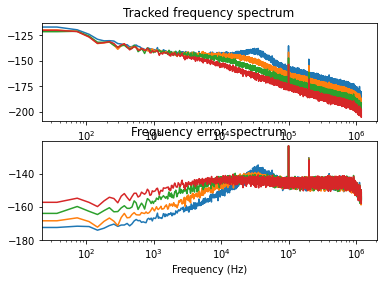

In [65]:
gain = [4096, 2048, 1024, 512]

for g in gain:
    
    S.set_feedback_gain(band=0, val=g)
    f, dF, sync = S.take_debug_data(band=0, channel=0, nsamp=2**19, IQstream=0, single_channel_readout=2)
    
    plt.subplot(211)
    freq, pxx = signal.welch(f, nperseg=len(f)/8, fs=2.4e6)
    plt.semilogx(freq, 10*np.log10(pxx))
    plt.xlabel('Frequency (Hz)')
    plt.title('Tracked frequency spectrum')
    
    plt.subplot(212)
    freq, pxx = signal.welch(dF, nperseg=len(f)/8, fs=2.4e6)
    plt.semilogx(freq, 10*np.log10(pxx))
    plt.xlabel('Frequency (Hz)')
    plt.title('Frequency error spectrum')
    


Finally we need to setup the streaming data rate.  This should be an integer divisor of 2.4MHz.  Let's start with 10kHz.

In [62]:
S.set_flux_ramp_freq(10) # set streaming rate, kHz

The frequency data (see above) is multiply and accumulated by a single coefficient (default operation, boxcar filter) or a runtime programmable window during the flux ramp.   For 10kHz this is 240 length.

$$ 2400000/10000 = 240$$

Let's set the boxcar coefficient to 1/240 to maintain filter gain.


In [29]:
epics_base0 = 'smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:'

coef       = 1/240
coef_fixed = np.round(coef*2**15)

epics.caput( epics_base0 + 'boxcarScale', coef_fixed)

1

Note we had to round our coefficient for Fix16_15 data type.  This will introduce a gain in streaming data of

In [32]:
print(coef_fixed*240*2**-15)

1.00341796875


We can instead use a programmable window (max length = 2048, 1.2kHz min streaming). Let's program a window of 240 length for the streaming data.  Not it should have

$$ sum(window) = 1 $$

Note the window has a max length of 2048 (at least 1.2kHz resets)

Filter gain is : 0.99981689453125


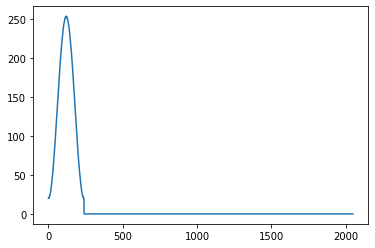

In [47]:
epics_base0 = 'smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:'
win       = signal.hamming(240)
win       = win/np.sum(win)

win_fixed            = np.zeros(2048, dtype=np.int16)

win_fixed[:len(win)] = np.round(win*2**15) # for firmware Fix16_15 data type


# select programmable window
epics.caput(epics_base0 + 'filtSel', 1)

# program window
epics.caput(epics_base0 + 'StreamingFilter:coefficientArray', win_fixed)

filter_gain = np.sum(win_fixed*2**-15)

# print filter gain
print(f'Filter gain is : {filter_gain}')

plt.plot(win_fixed)

Let's do a concrete example with the hamming window above:

Streamed data is filtered/downsampled
Then PySmurf/downstream processing needs to apply small correction gain based on programmed window

[ 2020-10-12 18:48:28 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:readoutChannelSelect 0
[ 2020-10-12 18:48:28 ]  Writing to file : /data/smurf_data/20201009/1602257653/outputs/1602528509.dat
[ 2020-10-12 18:48:28 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2020-10-12 18:48:28 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2020-10-12 18:48:28 ]  Data acquisition in progress...
[ 2020-10-12 18:48:28 ]  caput smurf_server_s2:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2020-10-12 18:48:31 ]  Done taking data


Text(0.5, 0, 'Time (uS)')

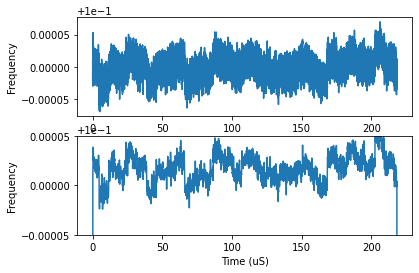

In [86]:
f, dF, sync = S.take_debug_data(band=0, channel=0, nsamp=2**19, IQstream=0, single_channel_readout=2)
t           = np.arange(len(f))*1000/2.4e6

# This happens in for streaming
win         = signal.hamming(240)
win         = win/np.sum(win)
win_fixed   = (np.round(win*2**15)*2**-15)
win_gain    = sum(win_fixed)



f_filt      = np.convolve(win, f)
# this is our streamed data
f_filt_ds   = f_filt[1::240]

# our streaming data needs a small gain correciton
f_filt_corr = f_filt_ds/win_gain
t_ds        = np.arange(len(f_filt_corr))*1000*240/2.4e6

plt.subplot(211)
plt.plot(t, f)
plt.ylabel('Frequency')
plt.xlabel('Time (uS)')
plt.subplot(212)
plt.plot(t_ds, f_filt_corr)
plt.ylim((0.09995, 0.10005))
plt.ylabel('Frequency')
plt.xlabel('Time (uS)')

In [63]:
S.flux_ramp_on()
S.take_noise_psd(5, make_channel_plot=True)

[ 2020-10-09 20:30:11 ]  Reading /data/smurf_data/20201009/1602257653/outputs/1602275263.dat
Processing data records from /data/smurf_data/20201009/1602257653/outputs/1602275263.dat
Processed 0 data records from /data/smurf_data/20201009/1602257653/outputs/1602275263.dat
Processed a total of 0 data records


UnboundLocalError: local variable 'phase' referenced before assignment

### Examine DAC output
We can again look at the DAC output but this time we will be playing tones and doing flux ramp tracking:


[ 2020-10-06 23:26:21 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 65536
[ 2020-10-06 23:26:21 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2020-10-06 23:26:21 ]  DAC plot saved to /data/smurf_data/20201006/1602026584/plots/1602026781_dac0.png
[ 2020-10-06 23:26:21 ]  Saving raw dac data to /data/smurf_data/20201006/1602026584/outputs/1602026781_dac0


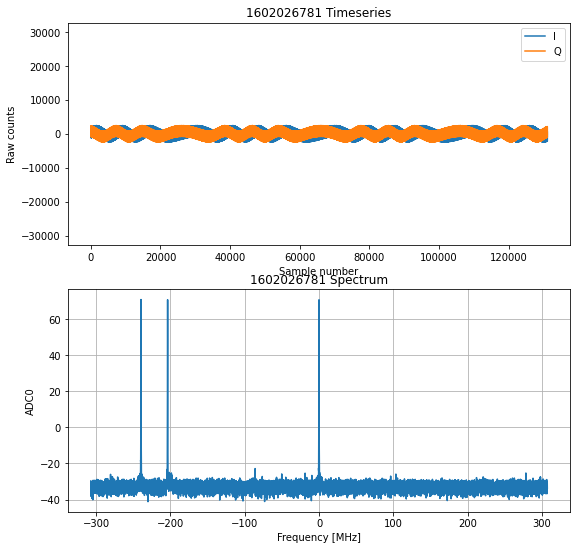

In [12]:
dac_data = S.read_dac_data(data_length=2**16, band=0, do_plot=True, show_plot=True)

[ 2020-10-06 23:26:22 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 65536
[ 2020-10-06 23:26:22 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2020-10-06 23:26:23 ]  ADC plot saved to /data/smurf_data/20201006/1602026584/plots/1602026783_adc0.png
[ 2020-10-06 23:26:23 ]  Saving raw adc data to /data/smurf_data/20201006/1602026584/outputs/1602026783_adc0


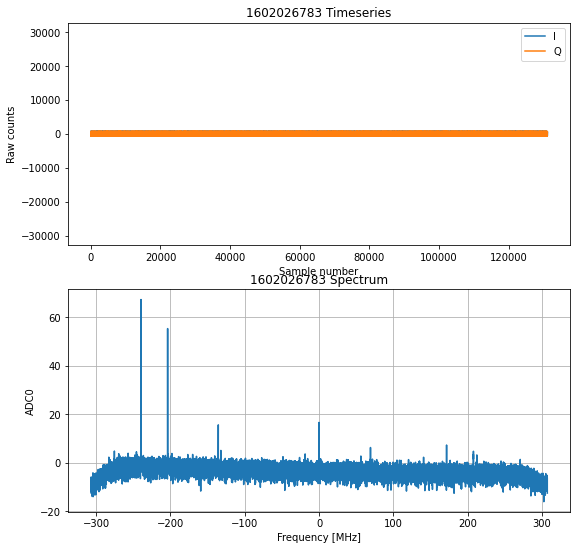

In [13]:
adc_data = S.read_adc_data(data_length=2**16, band=0, do_plot=True, show_plot=True)

Our resonator at 0MHz had the largest depth and we can see the power at the ADC is lowest.

In [48]:
S.set_amplitude_scale_channel(0, 0, 10)
S.set_center_frequency_mhz_channel(0, 0, 0.1)
S.run_serial_eta_scan(0)

In [ ]:
f, dF, sync = 